In [11]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')
sys.path.remove('/home/terudel/Documents/code/MuseoToolBox')

![](img/workflow_1.png)

## Extraction des échantillons

### Extraction à partir d'un fichier de point

#### Principe

Dans le cas d'un fichier de points, le problèmes est assez évident : il s'agit de trouver le pixel sur lequel se trouve un point et d'extraire sa valeur. Nous allons donc passer par les étapes suivantes :

![](img/extraction_point.png)

#### Conversion des coordonnées géographiques en coordonnées images

Il est possible de trouver les coordonnées *image* d'un pixel à partir de ses coordonnées géographiques :

![](img/coordonnées.png)

$$x_s = \frac{(x − x_0)}{pixelWidth}$$
$$y_s = \frac{(y − y_0)}{pixelHeight}$$

**Exercice** définir une fonction `xy_to_rowcol()` qui retourne la ligne et la colonne d'un pixel à partir des coordonnées d'une image et de l'image  

In [1]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')
import read_and_write as rw

def xy_to_rowcol(x, y, image_filename):
    """
    """
    # get image infos
    data_set = rw.open_image(image_filename)
    origin_x, origin_y = rw.get_origin_coordinates(data_set)
    psize_x, psize_y = rw.get_pixel_size(data_set)
    
    # convert x y to row col
    col = int((x - origin_x) / psize_x)
    row = - int((origin_y - y) / psize_y)
    
    return row, col

#### Extraction des coordonnées géographiques d'un fichier de point

Cette étape pose la question plus générale de la lecture de fichiers vecteurs en python. Comment faire ? Plusieurs librairies existent pour ce faire. Afin de varier la diversité des exemples vu pendant les cours, nous allons utiliser la librairie [==GeoPandas==](https://geopandas.org/). Par ailleurs, [==GeoPandas==](https://geopandas.org/) est basée sur la librairie [==Pandas==](https://pandas.pydata.org/docs/user_guide/index.html#user-guide) qui permet de gérer des tableaux de type `DataFrame`. 

Digression :  Qu'est ce que [==Pandas==](https://pandas.pydata.org/docs/user_guide/index.html#user-guide) et à quoi sert la librairie ? 

Il s’appuie sur ==NumPy== et permet de manipuler de grands volumes de données, structurées de manière simple et intuitive sous forme de tableaux. Pour faire simple Numpy est très performmant pour faire des calculs sur les données numériques. Mais dès qu'il sagit d'indexer des données variées, de différents type, ça devient compliqué. Possible, mais compliqué. C'est là où intervient [==Pandas==](https://pandas.pydata.org/docs/user_guide/index.html#user-guide).

Le type de base est la Serie (`pandas.Series'`) qui peut être considérée comme un tableau de données à une dimension (grossièrement équivalent à une liste). L’extension en deux dimensions est un DataFrame (`pandas.DataFrame`). C’est un simple tableau dont les séries constituent les colonnes. Les index sont:

- index de colonne (`df.columns()`): les noms des colonnes (généralement des chaînes de caractères);
- index de ligne (`df.index()`): nombres entiers (numéros des lignes), chaînes de caractères, `DatetimeIndex` ou `PeriodIndex` pour les séries temporelles (time series).

![](img/panda.png)

C’est l’équivalent d’une matrice NumPy dont chaque colonne (Serie) est de même type (n’importe quel type de données, objets Python, nombres, dates, textes, binaires) et qui peut contenir des valeurs manquantes. C’est aussi l’équivalent des Data Frame de R.

La syntaxe n'est pas évidente à prendre en main. Elle diffère sensiblement de celle de ==Numpy==, aussi nous utilserons des syntaxes élementaires pour manipuler ces objets. 

Pour plus d'infos vous pouvez vous référer : 

- à ce [site](https://portailsig.org/content/python-geopandas-ou-le-pandas-spatial.html) dont sont issues bon nombre des explications que vous lisez ;
- à la documentation de [==Pandas==](https://pandas.pydata.org/docs/user_guide/index.html#user-guide) : https://pandas.pydata.org/docs/user_guide/index.html#user-guide)

Et GeoPandas dans tout ça ? 

GeoPandas est en quelque sorte le PostGIS de Pandas : elle rajoute une dimension spatiale aux données d'un `DataFrame` et la possibilité de réaliser des opérations géométriques sur les données. 

Cette librairie rajoute les GeoSeries (géométries, en bleu clair) et les GeoDataFrames ou DataFrames avec une colonne GeoSerie aux structures de Pandas (GeoPandas: Data Structures). Le résultat final est une structure où tous les traitements de Pandas sont possibles sur les colonnes oranges (attributs, Panda Series) et les traitements géomatiques sur la colonne bleu clair (geospatial, Geopandas GeoSerie). En pratique une GeoSerie est constituée de géométries de la bibliothèque ==Shapely==.  Une ligne d'un GeoDataFrame contient donc les attributs et la géométrie d'un élément.

![](img/geopandas.png)

Et donc ? 

Et donc les GeoDataFrames sont très utiles pour lire, écrire, manipuler des données vecteurs. Dans ces TDs nous ne ferons qu'effleurer les nombreuses possibilités qu'offre GeoPandas car l'objectif est avant tout la manipulation de données raster. Garder dans un coin de votre tête l'existence des ces librairies. 

*Fin de la digression*

Nous allons donc utiliser la librairie ==GeoPandas==. Avant de continuer, vous pourrez tout de même trouver un exemple de lecture de fichier vecteur avec la librairie ==OGR== (d'osgeo) :

In [2]:
from osgeo import ogr

def get_geographic_coord_from_points(vector, field_name=None):
    """
    Get the geographic coordinates of a point vector file .
    Parameters
    ----------
    vector : str
        Path of the input vector file, any format supported by ogr.
    field_name : str, optional
        Field of the shapefile containing the id of each point.

    Return
    ------
    coord : list or dict
        If field_name is not indicated, list of coordinates (tuple) : [(x,y)].
        Else, dict of coordinates : {id_point : (x,y)}
    """
    # Get geographic coordinates of each point
    dataSource = ogr.Open(vector, 0)
    layer = dataSource.GetLayer()

    if not field_name:
        coord = []
    else:
        coord = {}
    for feature in layer:
        geom = feature.GetGeometryRef()
        pt = geom.Centroid().ExportToWkt()    # String
        coord_f = eval(','.join(pt.split(' ')[1:]))    # Transform into tuple
        if not field_name:
            coord.append(coord_f)
        else:
            coord[feature.GetField(field_name)] = coord_f
    driver = None
    return coord

C'est beaucoup plus simple, il vous suffit de lire le fichier :

In [1]:
import geopandas as gpd
fichier_point = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/sample_strata_centroides.shp'
gdf = gpd.read_file(fichier_point)
print('type of gdf : ', type(gdf))
gdf

type of gdf :  <class 'geopandas.geodataframe.GeoDataFrame'>


num         class   id                        geometry
0      1        sol nu  527  POINT (748365.906 6276577.033)
1      4  ligneux haut    1  POINT (748285.153 6276558.825)
2      2         herbe    2  POINT (748401.722 6276762.504)
3      3   ligneux bas    3  POINT (748325.353 6276728.435)
4      1        sol nu    4  POINT (748586.873 6276687.753)
..   ...           ...  ...                             ...
519    2         herbe  522  POINT (750142.636 6273994.320)
520    2         herbe  523  POINT (750336.872 6273995.490)
521    2         herbe  524  POINT (750641.804 6273889.907)
522    2         herbe  525  POINT (750915.411 6273803.283)
523    2         herbe  526  POINT (751125.608 6274036.404)

[524 rows x 4 columns]

Vous pouvez maintenant accéder à la colonne `geometry` du `GeoDataFrame` :

In [2]:
gdf.loc[:,'geometry']

0      POINT (748365.906 6276577.033)
1      POINT (748285.153 6276558.825)
2      POINT (748401.722 6276762.504)
3      POINT (748325.353 6276728.435)
4      POINT (748586.873 6276687.753)
                    ...              
519    POINT (750142.636 6273994.320)
520    POINT (750336.872 6273995.490)
521    POINT (750641.804 6273889.907)
522    POINT (750915.411 6273803.283)
523    POINT (751125.608 6274036.404)
Name: geometry, Length: 524, dtype: geometry

et accéder de manière élémentaire à une géométrie en particulier : 

In [3]:
a_geometry = gdf.loc[0,'geometry'] 
print(a_geometry)
print(type(a_geometry))

POINT (748365.9064233786 6276577.033433291)
<class 'shapely.geometry.point.Point'>


Au passage, nous avons vu :

- qu'une geométrie était une geométrie de la librairie ==Shapely== et type `Point`.
- qu'on pouvait indexer un `DataFrame` (et *a fortiori* un `GeoDataFrame`) à la l'aide des instructions `gdf.loc[mes_lignes, mes_colonnes]`

Récuperons maintenant les coordonnées de notre point :

In [4]:
print(list(a_geometry.coords))
x = a_geometry.x
y = a_geometry.y

[(748365.9064233786, 6276577.033433291)]


Vous pouvez récuperer l'ensemble des coordonnées x, y à partir de la `GeoSeries` :  

In [5]:
print(gdf.loc[:,'geometry'].x)
print(gdf.loc[:,'geometry'].y)

0      748365.906423
1      748285.153170
2      748401.721924
3      748325.352732
4      748586.873167
           ...      
519    750142.635951
520    750336.872357
521    750641.804023
522    750915.410987
523    751125.607798
Length: 524, dtype: float64
0      6.276577e+06
1      6.276559e+06
2      6.276763e+06
3      6.276728e+06
4      6.276688e+06
           ...     
519    6.273994e+06
520    6.273995e+06
521    6.273890e+06
522    6.273803e+06
523    6.274036e+06
Length: 524, dtype: float64


Remarque : les coordonnées récupérées sont de type `Series` :

In [6]:
print(type(gdf.loc[:,'geometry'].y))

<class 'pandas.core.series.Series'>


Vous pouvez extraire les données brutes (tableau numpy) ce faisant : 

In [7]:
list_x = gdf.loc[:,'geometry'].x.values
list_y = gdf.loc[:,'geometry'].y.values
print(type(list_x))

<class 'numpy.ndarray'>


Exercice : écrire une fonction qui renvoie les coordonnées géographiques d'un fichier de point en utilisant ==Geopandas==

In [10]:
import geopandas as gpd

def get_xy_from_file(filename):
    """
    Get x y coordinates from a vector point file
    
    Parameters
    ----------
    filename : str
        Path of the vector point file
        
    Returns
    -------
    list_x : np.array
    list_y : np.array
    """
    gdf = gpd.read_file(filename)
    geometry = gdf.loc[:, 'geometry']
    list_x = geometry.x.values
    list_y = geometry.y.values
    
    return list_x, list_y

Nous verrons pas plus d'éléments de l'API de la librairie Shapely. Vous pourrez cependant trouver une documentation détaillée des fonctionnalités de cette librairie [ici](https://shapely.readthedocs.io/en/stable/manual.html).

Noous pouvons maintenant définir une fonction qui `get_row_col_from_file` à partir des fonctions précédemment définies et qui renvoient les coordonnées images de chaque point d'un fichier de point :

In [9]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')
import read_and_write as rw

image_filename = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/aumelas_orthoirc.tif'
point_filename = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/sample_strata_centroides.shp'
list_row, list_col = rw.get_row_col_from_file(point_filename, image_filename)

Exercice facultatif

Bien que cette fonction vous soit déjà fournie, réaliser cette fonction. 

In [13]:
def get_row_col_from_file(point_file, image_file):
    """
    Getrow col image coordinates from a vector point file
    and image file

    Parameters
    ----------
    point_file : str
        Path of the vector point file
    image_file : str
        Path of the raster image file

    Returns
    -------
    list_row : np.array
    list_col : np.array
    """
    list_row = []
    list_col = []
    list_x, list_y = get_xy_from_file(point_file)
    for x, y in zip(list_x, list_y):
        row, col = xy_to_rowcol(x, y, image_file)
        list_row.append(row)
        list_col.append(col)
    return list_row, list_col

#### Lecture des valeurs et formattage

Vous savez maintenant : 

- extraire les coordonnées geographiques d'un fichier de point
- convertir ces coordonnées en coordonnées images

Par ailleurs nous avons vu dans les précédents TDs comment accéder aux valeurs d'un pixel d'une image à partir de ces coordonnées :

In [23]:
import read_and_write as rw

image_filename = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_intro/data/Pleiades/fabas_12_10_2013_reordered.tif'
point_filename = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/sample_l93.shp'
list_row, list_col = rw.get_row_col_from_file(point_filename, image_filename)

image = rw.load_img_as_array(image_filename)
X = image[(list_row, list_col)]
print(X)

[[ 261  193  116  579]
 [ 259  185  122  633]
 [ 248  160  100  356]
 ...
 [ 307  256  181 1015]
 [ 302  255  176  934]
 [ 290  235  155  993]]


Remarque, dans la suite du TDs, nous aurons besoins de formmater les données selon le format suivant :

![](img/tableau_numpy_echantillons.png)

Question : la matrice X est-elle bien formatée ? Vérifiez le formellement en python. 

In [29]:
import geopandas as gpd

data_set = rw.open_image(image_filename)
image_filename = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_intro/data/Pleiades/fabas_12_10_2013_reordered.tif'
fichier_point = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/sample_l93.shp'
gdf = gpd.read_file(fichier_point)

print('Shape of X :', X.shape)
print('Number of bandes :', rw.get_image_dimension(data_set)[2])
print('Number of samples : ', gdf.shape[0] )

Shape of X : (421, 4)
Number of bandes : 4
Number of samples :  421


**Et à quoi correspond ce tableau Y dans la figure ?** 

Si la matrice `X` correspondant aux variables à classer, la matrice `Y` correspond aux labels de chaque points, c'est à dire à quelle classe ils appartiennent. 

**Et comment l'obtient-on ?** 

Exercice :

À vous de me le dire. 

Indices : 
- à partir du fichier d'échantillons
- attention au format en sortie (voir figure)

In [41]:
import geopandas as gpd
import numpy as np

fichier_point = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/sample_l93.shp'
gdf = gpd.read_file(fichier_point)
Y = gdf.loc[:, 'Label'].values
Y = np.atleast_2d(Y).T

### Extraction à partir d'un fichier de polygone

#### Principe

Dans le cas des fichiers de points, un point équivaut à un pixel. Trouver ce pixel est simple. Dans le cas de fichiers de polygones, un polygone équivaut à plusieurs pixels, et il est moins simple de récuperer les pixels qui les contiennent en utilisant la librairies ==GeoPandas==. Nous allons donc voir une autre approche.

Le principe est le suivant :

![](img/extraction_polygone.png)

Il s'agit de créer une image d'échantillons en rasterisant le fichier vecteur. L'image créée aura les mêmes dimensions x,y que l'image qu'on cherche à classer et la même taille de pixel. Une fois cette image obtenue, il est facile d'extraire les pixels de l'image qui correspondent à des pixels échantillons à l'aide de ==Numpy==.

#### Rasterisation

**Digression : Appel d'une application en ligne de commande**

Vous connaissez déjà l'OTB et ces applications. Nous allons voir comment appeler ces applications depuis python. 

L'OTB possède en elle même une syntaxe qui permettent d'appeler ses applications via une interface python : 

```python
import otbApplication

app = otbApplication.Registry.CreateApplication("Rasterization")

app.SetParameterString("in", "qb_RoadExtract_classification.shp")
app.SetParameterString("out", "rasterImage.tif")
app.SetParameterFloat("spx", 1.)
app.SetParameterFloat("spy", 1.)

app.ExecuteAndWriteOutput()
```

Je vous propose cependant de ne pas utiliser cette interface et de passer par les applications en ligne de commande. Vous saurez également lancer d'autres applications en ligne de commande comme par ex. l'application [`gdal_polygonize.py`](https://gdal.org/programs/gdal_polygonize.html). 

Nous allons pour cela utiliser la bibliothèque `subprocess`: 

In [ ]:
import subprocess 
cmd = 'gdal_polygonize.py raster.tif raster_vectorisee.shp'

# if just want to run the command
subprocess.run(cmd)

# if you want to get shell output
result = subprocess.check_output(cmd, shell=True, stderr=subprocess.STDOUT)

Le principe est d'écrire la ligne de commande sous forme de chaîne de caractère, puis d'exécuter cette chaîne de caractère à l'aide des fonctions `run()` ou  `check_output()` si vous voulez pouvoir récupérer des éventuels messages d'erreur. 

**Cas d'application pour l'application OTB `otbcli_Rasterization`**

In [17]:
import os
import subprocess 

# define parameters
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
in_vector = os.path.join(my_folder, 'sample_strata_centroides.shp')
ref_image = os.path.join(my_folder, 'aumelas_orthoirc.tif')
out_image = os.path.splitext(in_vector)[0] + '.tif'
out_image = os.path.join(my_folder, 'sample_strata_centroides.tif')
field_name = 'num'  # field containing the numeric label of the classes

# define commande
cmd_pattern = ("otbcli_Rasterization -in {in_vector} -im {ref_image} -out {out_image}"
               " -mode attribute -mode.attribute.field {field_name}")
cmd = cmd_pattern.format(in_vector=in_vector, ref_image=ref_image,
                         out_image=out_image, field_name=field_name)


In [18]:
# pour python >= 3.7
result = subprocess.check_output(cmd, shell=True, stderr=subprocess.STDOUT)
print(cmd)
print(result.decode())

otbcli_Rasterization -in /home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/sample_strata_centroides.shp -im /home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/aumelas_orthoirc.tif -out /home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/sample_strata_centroides.tif -mode attribute -mode.attribute.field num
2021-01-06 10:58:14 (INFO) Rasterization: Default RAM limit for OTB is 256 MB
2021-01-06 10:58:14 (INFO) Rasterization: GDAL maximum cache size is 1596 MB
2021-01-06 10:58:14 (INFO) Rasterization: OTB will use at most 12 threads
2021-01-06 10:58:14 (INFO) Rasterization: Input dataset extent is (748233, 6.2738e+06) (751217, 6.27679e+06)
2021-01-06 10:58:14 (INFO) Rasterization: Input dataset projection reference system is: PROJCS["RGF93 / Lambert-93",GEOGCS["RGF93",DATUM["Reseau_Geodesique_Francais_1993",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6171"

**Remarques** :
- si vous n'avez pas bien configuré votre environnement virtuel, vous ne pourrez pas lancer des applications OTBs, je pense notamment à la partie [Configuration d'OTB dans le nouvel environnement de travail](https://mlang.frama.io/sigma-teledec-avancee/installation.html#configuration-dotb-dans-le-nouvel-environnement-de-travail)
- rar défaut, les pixels qui ne correspondent à aucun échantillon auront 0 comme valeur. 

**Exercie** appliquer la rasterisation à votre jeu d'échantillons. 

#### Lecture des valeurs de l'image

Le principe est le même que précédemment : on va essayer de récuperer une matrice `X` contenant les valeurs spectrales des échantillons et une matrice `Y` contenant les labels numériques de ces images : 

![](img/tableau_numpy_echantillons.png)

Vous disposez pour ce faire d'une fonction `get_samples_from_roi()` disponible dans le script `classification.py`

Exercice :

- Utilisez cette fonction pour extraire les matrices `X` et `Y`. 
- Vérifier que X et Y ont des dimensions cohérentes.

Indice : 
- Vous pouvez obenir l'aide de la fonction en tapant `help(get_samples_from_roi)` une fois celle-ci importée. 

In [5]:
import classification as cla

In [51]:
help(cla.get_samples_from_roi)

Help on function get_samples_from_roi in module classification:

get_samples_from_roi(raster_name, roi_name, value_to_extract=None, bands=None, output_fmt='full_matrix')
    The function get the set of pixel of an image according to an roi file
    (vector or raster). In case of raster format, both map should be of same
    size.
    
    Parameters
    ----------
    raster_name : string
        The name of the raster file, could be any file GDAL can open
    roi_name : string
        The path of the roi image.
    value_to_extract : float, optional, defaults to None
        If specified, the pixels extracted will be only those which are equal
        this value. By, defaults all the pixels different from zero are
        extracted.
    bands : list of integer, optional, defaults to None
        The bands of the raster_name file whose value should be extracted.
        Indexation starts at 0. By defaults, all the bands will be extracted.
    output_fmt : {`full_matrix`, `by_label` }, 

In [6]:
import os
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
sample_filename = os.path.join(my_folder, 'sample_strata.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')
X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
print(X.shape)
print(Y.shape)

(25557, 3)
(25557, 1)


In [43]:
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
sample_filename = os.path.join(my_folder, 'sample_strata_id.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')
_, Y_id, _ = cla.get_samples_from_roi(image_filename, sample_filename)

Exercie facultatif (pour la prochaine séance): 

Ouvrez le script `classification.py` est essayez d'expliquer son principe, même si vous ne comprenez pas toutes les lignes de code. 

In [44]:
X.shape
print(Y.shape)
print(Y_id.shape)

(25557, 1)
(25557, 1)


In [46]:
strati = np.concatenate((Y, Y_id), axis=1)
strati.shape

(25557, 2)

## Entrainement et validation du model

Nous allons maintenant parler de la partie classification (ou *Machine Learning* si vous voulez faire chic). Nous verrons dans cette partie comment :

- réaliser l'apprentissage d'un classifieur à partir d'une matrice `X` d'échantillons
- évaluer ce modèle

![](img/entrainement_validation_v0.png)

**Digression : Scikit learn**

==Scikit-learn== est LA librairie python pour le Machine Learning. Vous pourrez y trouver :

- des modèles de classification supervisée
- des modèles de classification non supervisée
- des modèles de regressions
- des modèles de préparation des jeux de données
- de modèles de réduction de dimensions
- et d'autres ...

Mais aussi de nombreux exemples illustrés. Voyez ci-dessous un exemple de comparaison de classifieur.  

![](img/comparaison_classifieur.png)

Vous trouverez [ici](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) le code utilisé pour produire cette figure. 


### Entrainement 

L'entrainement consiste à déterminer les règles de décisions qui permettront d'assigner un label à un pixel. Il existe plusieurs algorithmes de classification. Nous allons dans cet exemple l'algorithme de classification arbre de décision mais la syntaxe reste la même pour tout classifieur. 

La première consiste toujours à initialiser un classifieur, ici un arbre de décision, mais qui se nommera `DecisionTreeClassifier`

In [3]:
#from sklearn.svm import SVC
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_leaf_nodes=10)

**Et les Hyper-paramètres**

Vous avez raison ! Généralement les algoritmes de classificaitons ont des paramètres qu'il faut définir *a priori de la classification*. 

<!-- Dans le cas de SVM, ce sont principalement les paramètres, `C`, `gamma` et `kernel` qui doivent être définis avec précaution. Il existe également d'autres paramètres dont la liste est disponible [ici](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) -->

La liste des paramètres est disponible [ici](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) Ne nous préoccupons pas de ça pour le moment, tout hyperparamètre possède une valeur par defaut.

L'étape suivante consiste à utiliser la méthode `fit()` du modèle. Tout modèle de classification possède une méthode `fit`

In [4]:
# Train
clf.fit(X, Y)

DecisionTreeClassifier(max_leaf_nodes=10)

Après cette étape, les règles de décisions (ou paramètres du modèle) sont stockées dans l'objet clf et peuvent être appliquées à n'importe quel autre jeu de données. Une image ou un jeu de validation par exemple. 

Dans le cas des arbres de décision, cest paramètres sont très visuels et il est possible de les afficher : 

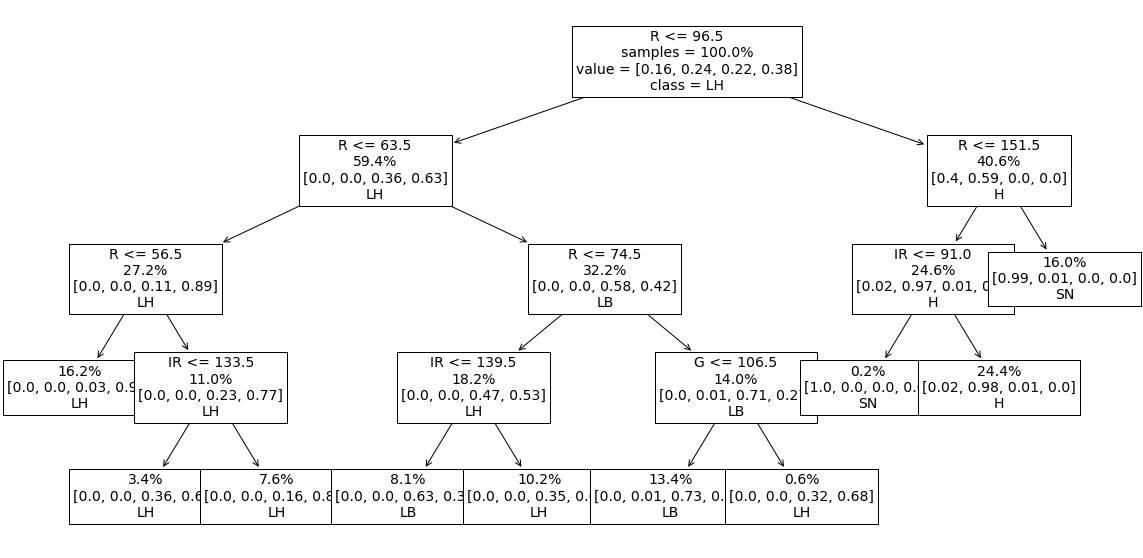

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))
my_tree = tree.plot_tree(clf, ax=ax, fontsize=14, 
                         feature_names=['IR', 'R', 'G'],
                         class_names=['SN', 'H', 'LB', 'LH'],
                         label='root', impurity=False, proportion=True,
                         precision=2)

Notez bien que pour d'autres algorithmes, les règles de décisions peuvent être beaucoup plus abstraites et difficilement interprétables.

### Validation du modèle

Il s'agit maintenant d'évaluer la qualité du modèle entrainement. Nous allons utiliser le modèle entrainé pour prédire un jeu de donnée dont on connait les labels. La prédiction se fait via la méthode `predict` d'un classifieur : 

In [9]:
# Test
Y_predict = clf.predict(X)

Remarque : dans notre cas, nous avons prédit les labels du jeu de données qui a servi pour l'entrainement, c'est un mauvaise pratique. Nous reviendrons dessus plus tard mais faisons abstraction pour le moment.

Comparons maintenant les labels prédits avec les véritables labels. Pour ce faire, scikit-learn met à disposition de nombreuses fonctions via le module `metrics`

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import numpy as np

# Compute the confusion matrix
cm = confusion_matrix(Y, Y_predict)

# Compute the quality metrics by classe.
report_str = classification_report(Y, Y_predict, labels=np.unique(Y))#, output_dict=True)

# Compute the overall accuracy
accuracy = accuracy_score(Y, Y_predict)

Matrice de confusion

In [11]:
print(cm)
print(type(cm))

[[4176    1    0    0]
 [   4 6166    0    0]
 [   0    1 5285  290]
 [   0    0  952 8682]]
<class 'numpy.ndarray'>


La matrice de confusion est retournée sous forme de tableau numpy. Au besoin vous pouvez l'enregistrée sous forme de fichier texte :

In [65]:
np.savetxt('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/cm.txt', cm)

Le rapport de classification est disponible par défaut sous forme de de chaîne de caractères qu'on peut afficher : 

In [12]:
print(report_str) 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4177
           2       1.00      1.00      1.00      6170
           3       0.85      0.95      0.89      5576
           4       0.97      0.90      0.93      9634

    accuracy                           0.95     25557
   macro avg       0.95      0.96      0.96     25557
weighted avg       0.95      0.95      0.95     25557



La qualité globale est retournée sous forme de `float` :

In [13]:
print(accuracy)

0.9511679774621434


Exercice :

- Entrainez votre premier modèle et évaluer sa qualité.
- Testez différents paramètres `C` et `gamma` et regarder l'évolution des résultats 

### Validation : un peu de swag s'il vous plait 

Pour le moment, vous avez obtenu des indices de qualités de votre modèle sous forme de texte ou de matrice : ce n'est encore pas facile à exploiter, et a fortiori pas facile à communiquer non plus. Voyons commment nous pourrions mettre en forme tout ça.

#### Matrice de confusion

Nous allons mettre en forme la matrice de confusion sous de figure pour qu'elle soit plus lisible. Pour cela nous allons utiliser la librairie ==museotoolbox== (documentation [ici](https://museotoolbox.readthedocs.io/en/latest/)) qui permet, entre autres choses, de faire des matrices de confusions plus informatives qu'un simple print d'une matrice numpy.

Nous allons notamment utiliser la classe `PlotConfusionMatrix` du module `charts` :

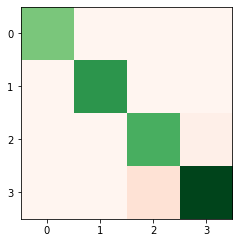

In [14]:
from museotoolbox.charts import PlotConfusionMatrix
from matplotlib.pyplot import cm as colorMap

pltCm = PlotConfusionMatrix(cm, cmap=colorMap.YlGn)
pltCm.color_diagonal(diag_color=colorMap.Greens,
                         matrix_color=colorMap.Reds)

Pour le moment vous pouvez voir une matrice où les accords sont indiqués en vert les confusions en rouge. Ajoutons maintenant des informations textuelles :

/home/terudel/anaconda3/envs/sigma-env/lib/python3.8/site-packages/museotoolbox/charts/__init__.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(


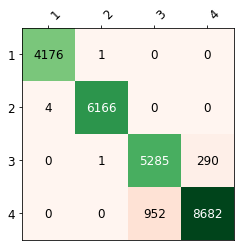

In [15]:
pltCm = PlotConfusionMatrix(cm, cmap=colorMap.YlGn)


pltCm.add_text(font_size=12)
pltCm.add_x_labels(np.unique(Y), rotation=45)
pltCm.add_y_labels(np.unique(Y))

pltCm.color_diagonal(diag_color=colorMap.Greens,
                         matrix_color=colorMap.Reds)


Vous avez maintenant le nombre d'échantillons affiché, et les labels des classes ont été modifiés. 

Une matrice de confusion est utile pour repérer les confusions entre les classes. C'est aussi à partir de celle-ci que vous pouvez avoir accès à la qualité de chaque classe. Il est possible de les afficher avec la classe `PlotConfusionMatrix` :

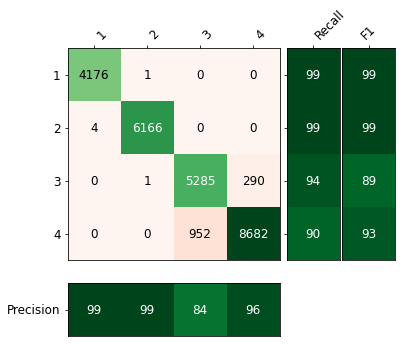

In [16]:
pltCm = PlotConfusionMatrix(cm, cmap=colorMap.YlGn)

pltCm.add_text(font_size=12)
pltCm.add_x_labels(np.unique(Y), rotation=45)
pltCm.add_y_labels(np.unique(Y))
pltCm.color_diagonal(diag_color=colorMap.Greens,
                         matrix_color=colorMap.Reds)
pltCm.add_accuracy(invert_PA_UA=False, user_acc_label='Recall',
                    prod_acc_label='Precision')
pltCm.add_f1()

Vous avez maintenant d'un seul coup d'oeil les informations les plus importantes pour évaluer la qualité de votre classification. 

#### Qualité des classes

Je vous propose de réaliser un autre graphique permettant de se concentrer sur la qualité des classes.

Pour cela nous allons utiliser le rapport de classification fourni par scikit learn. Cette fois-ci, récupérons les données sous forme de dictonnaire. Elles seront plus faciles à exploiter ainsi. 

In [17]:
report = classification_report(Y, Y_predict, labels=np.unique(Y), output_dict=True)
print(report)
print()
print(report['1'])

{'1': {'precision': 0.999043062200957, 'recall': 0.9997605937275557, 'f1-score': 0.999401699174345, 'support': 4177}, '2': {'precision': 0.9996757457846952, 'recall': 0.9993517017828201, 'f1-score': 0.9995136975198573, 'support': 6170}, '3': {'precision': 0.8473625140291807, 'recall': 0.9478120516499282, 'f1-score': 0.8947769406585965, 'support': 5576}, '4': {'precision': 0.9676772180115916, 'recall': 0.9011833091135562, 'f1-score': 0.9332473395678813, 'support': 9634}, 'accuracy': 0.9511679774621434, 'macro avg': {'precision': 0.9534396350066061, 'recall': 0.9620269140684651, 'f1-score': 0.95673491923017, 'support': 25557}, 'weighted avg': {'precision': 0.9542785897740484, 'recall': 0.9511679774621434, 'f1-score': 0.9516641820893712, 'support': 25557}}

{'precision': 0.999043062200957, 'recall': 0.9997605937275557, 'f1-score': 0.999401699174345, 'support': 4177}


Les indices sont ainsi bien rangées, par classe. Nous pourrions ainsi *parser* les informations afin d'extraire une liste de précisions et de rappel mais ce serait se compliquer la tache car ==Pandas== permet de faire ça automatiquement : 

In [18]:
import pandas as pd
report_df = pd.DataFrame.from_dict(report)
report_df

1            2            3            4  accuracy  \
precision     0.999043     0.999676     0.847363     0.967677  0.951168   
recall        0.999761     0.999352     0.947812     0.901183  0.951168   
f1-score      0.999402     0.999514     0.894777     0.933247  0.951168   
support    4177.000000  6170.000000  5576.000000  9634.000000  0.951168   

              macro avg  weighted avg  
precision      0.953440      0.954279  
recall         0.962027      0.951168  
f1-score       0.956735      0.951664  
support    25557.000000  25557.000000

Les informations sont cette fois-ci stockées dans un `DataFrame`. Dans cet exemple, nous ne nous intéresserons qu'aux trois metriques suivantes :
- precision
- recall
- f1-score

Débarrassons nous des autres informations :

In [19]:
# drop columns (axis=1) same as numpy
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1)
# drop rows (axis=0) same as numpy
report_df = report_df.drop(['support'], axis=0)
report_df

1         2         3         4
precision  0.999043  0.999676  0.847363  0.967677
recall     0.999761  0.999352  0.947812  0.901183
f1-score   0.999402  0.999514  0.894777  0.933247

Nous avons maintenant un tableau prêt à être exploité. Nous pourrions utiliser ces informations avec l'API de ==matplotlib==. Mais ==Pandas== à interfacer lui même certaines fonctions de ==matplotlib== (plus d'infos [ici](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)), ce qui va nous faciliter la tâche :

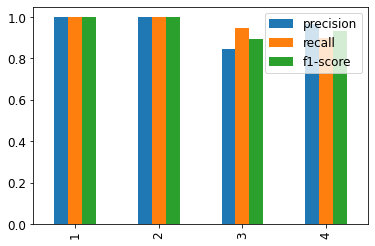

In [20]:
ax = report_df.T.plot.bar()

Pandas a automatiquement passé à matplotlib les différents labels et légendes contenus dans les colonnes et les lignes du `DataFrame`. Pratique non ? 

Bon vous avez maintenant quelque chose de plus visuelle mais on peut faire mieux. Et pour cela, il va falloir repasser par l'API de ==matplotlib==. Pas d'inquiétude, les deux API se marient plutôt bien.

Pour commencer nous allons créer une figure avec ==matplotlib==, récupérer une instance de `matplotlib.axes._subplots.AxesSubplot` dans la variable `ax` et la donner comme argument aux fonctions ==Pandas==

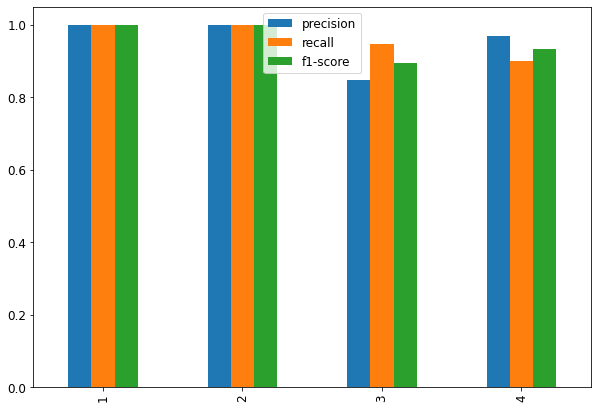

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,7))
ax = report_df.T.plot.bar(ax=ax)

Nous allons maintenant pouvoir ajouter des informations à notre graphique. Par exemple un titre, et tant qu'à faire rajouter l'accord global.

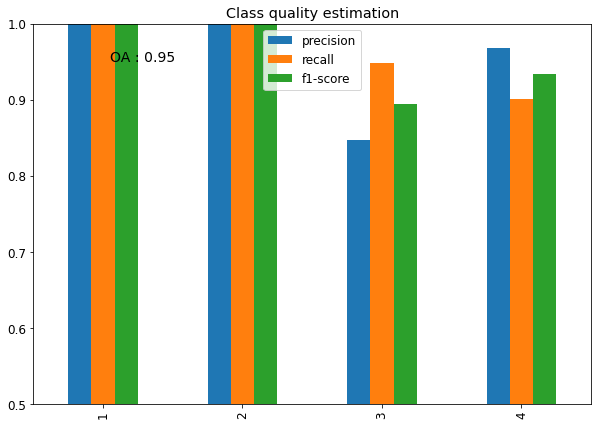

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,7))
ax = report_df.T.plot.bar(ax=ax, zorder=2)

# custom : information
ax.set_ylim(0.5, 1)
_ = ax.text(0.05, 0.95, 'OA : {:.2f}'.format(accuracy), fontsize=14)
_ = ax.set_title('Class quality estimation')

Rajoutons maintenant quelques élements graphiques pour que les informations soient encore plus lisibles :

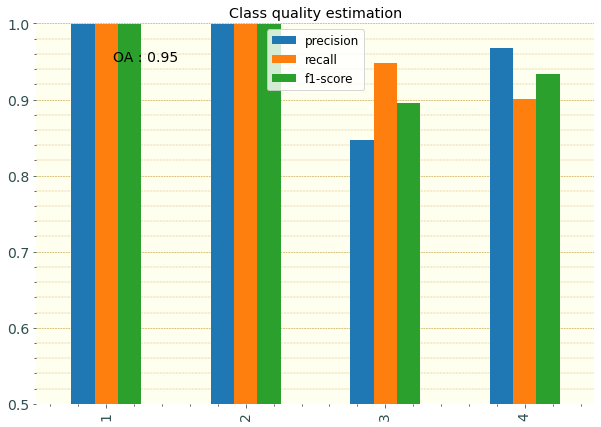

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,7))
ax = report_df.T.plot.bar(ax=ax, zorder=2)

# custom : information
ax.set_ylim(0.5, 1)
ax.text(0.05, 0.95, 'OA : {:.2f}'.format(accuracy), fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
                      linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
                      linewidth=0.3, zorder=1)

Exercice :

Reproduire les deux types de graphiques vu précédemment.  

## Application du modèle à l'ensemble de l'image

![](img/application_model_v0.png)

### Extraction de l'image 

De le même manière que pour les échantillons, nous allons devoir formater l'image sous forme d'une matrice `X` avec les pixels en lignes et les bandes spectrales en colonnes. 

Excercice : 

À partir du fichier image en entrée, écrivez des instructions qui permettent d'obtenir une matrice `X` qui soit utilisable ensuite par ==scikitlearn==. Plusieurs choix s'offrent à vous : 
1. vous pouvez utiliser une fonction que nous avons vu dans ce cours ;
2. vous pouvez charger l'image sous forme de matrice puis la re-formater.

Solution 1

In [26]:
import classification as cla
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')
sample_filename = image_filename
X_img, _, t_img = cla.get_samples_from_roi(image_filename, sample_filename)

Ici nous avons détourné la fonction `get_samples_from_roi` de son usage initial. Pour rappel, la fonction permet d'extraire les valeurs `image_filename` la où les pixels de la première bande de `sample_filename` sont différents de 0. Si `sample_filename = image_filename`, tous les pixels de l'image seront extraits =). Dans ce cas, nous n'avons par contre pas besoin des sorties `Y`.

Solution 2

In [25]:
import read_and_write as rw
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# load image
image = rw.load_img_as_array(image_filename)

# reshape image 
nb_band = image.shape[2]
X2 = image.reshape((-1, nb_band))

# remove pixel that equals to 0 on the first band
X2 = X2[X2[:, 0] != 0] 

Les deux solutions sont elles équivalentes ? 

In [91]:
print(np.equal(X_img, X2).all())

True


### Application du modèle sur l'image

Nous allons utiliser la méthode predict de notre classifieur `clf` précédemment entrainé : 

In [27]:
Y_predict = clf.predict(X_img)

`Y_predict` contient maintenant l'ensemble des labels de l'image. Cependant le format de la matrice n'est pas le bon pour qu'elle puisse être écrite directement. Voyons comment la formatter :

In [31]:
import read_and_write as rw
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# Get image dimension 
ds = rw.open_image(image_filename)
nb_row, nb_col, _ = rw.get_image_dimension(ds)

#initialization of the array
img = np.zeros((nb_row, nb_col, 1), dtype='uint8')
#np.Y_predict

img[t_img[0], t_img[1], 0] = Y_predict

In [28]:
Y_predict.shape

(35989034,)

### Ecriture de l'image

Vous avez développé lors des précédents TDs un fonction `write_image`. Elle est maintenant disponnible dans le script `read_and_write`.

Exercice : 

Écrire des instructions qui permettent d'appliquer le modèle sur l'ensemble de l'image puis d'écrire le résultat dans une image que vous nommerez `ma_premiere_classif_scikit.tif` (vous l'imprimerez et la collerez ensuite dans votre chambre : la classe).

Solution

In [33]:
import read_and_write as rw
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')
out_filename = os.path.join(my_folder, 'ma_premiere_classif_scikit.tif')

# get reference dataset 
ds = rw.open_image(image_filename)

# just replace the number of band (1 instead of 3)
rw.write_image(out_filename, img, data_set=ds, gdal_dtype=None,
                transform=None, projection=None, driver_name=None,
                nb_col=None, nb_ligne=None, nb_band=1)

Ouvrez maintenant votre image pour la visualiser et inspecter le résulat. 

- êtes vous satisfait.e.s de la qualité de la classif ? 
- est-elle conforme à ce qu'indique votre analyse des indices de qualité précédemment produits ? 

## Synthèse

Vous avez maintenant produit chaque étape séparamment, vous allez pouvoir vous faire un script qui enchaine toutes ces instructions. 

Exercice : 

- Ecrire l'enchainement des instructions qui permettent, à partir d'une image et d'un jeu d'échantillon, d'obtenir une image classifiée et deux figures permettant d'interpréter son évaluation. 

Astuces : vous avez à votre disposition dans un script `plots.py`
    

/home/terudel/Documents/code/MuseoToolBox/museotoolbox/charts/__init__.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(


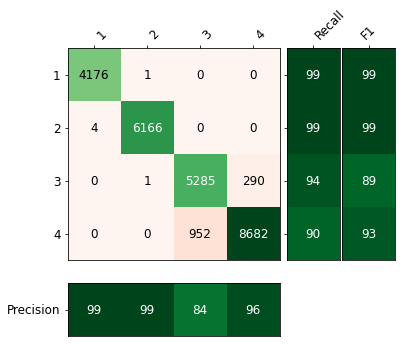

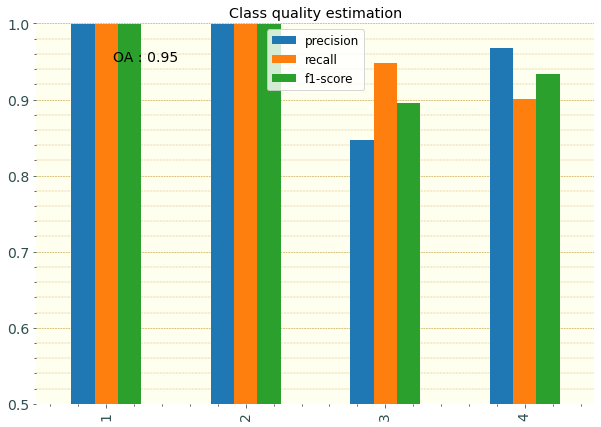

In [1]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')

import os
import numpy as np
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters 
# inputs
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
sample_filename = os.path.join(my_folder, 'sample_strata.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')
# outputs
out_classif = os.path.join(my_folder, 'ma_classif.tif')
out_matrix = os.path.join(my_folder, 'ma_matrice.png')
out_qualite = os.path.join(my_folder, 'mes_qualites.png')

# 2 --- extract samples 
X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)

# 3 --- Train
#clf = SVC(cache_size=6000)
clf = tree.DecisionTreeClassifier()
clf.fit(X, Y)

# 4 --- Test
Y_predict = clf.predict(X)

# compute quality
cm = confusion_matrix(Y, Y_predict)
report = classification_report(Y, Y_predict, labels=np.unique(Y), output_dict=True)
accuracy = accuracy_score(Y, Y_predict)

# display and save quality
plots.plot_cm(cm, np.unique(Y), out_filename=out_matrix)
plots.plot_classe_quality(report, accuracy, out_filename=out_qualite)

# 5 --- apply on the whole image

# load image
X_img, _, t_img = cla.get_samples_from_roi(image_filename, image_filename)

# predict image 
Y_predict = clf.predict(X_img)

# reshape 
ds = rw.open_image(image_filename)
nb_row, nb_col, _ = rw.get_image_dimension(ds)

#initialization of the array
img = np.zeros((nb_row, nb_col, 1), dtype='uint8')
img[t_img, t_img, 0] = Y_predict

# write image
ds = rw.open_image(image_filename)
rw.write_image(out_classif, img, data_set=ds, gdal_dtype=None,
            transform=None, projection=None, driver_name=None,
            nb_col=None, nb_ligne=None, nb_band=1)

In [15]:
import read_and_write as rw
fichier_point = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/sample_l93.shp'
image_filename = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_intro/data/Pleiades/fabas_12_10_2013_reordered.tif'

fichier_point = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/sample.shp'
image_filename = '/home/terudel/HyperBio/00_Data/images/hyspex/TOC/fab_hyspex_TOC_tightmosaic_04m_10nm.tif'

field_name = 'Label'
X, Y = rw.get_data_for_scikit(fichier_point, image_filename, field_name)

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.5, shuffle=True,
            stratify=strati)  # , random_state=0)

In [27]:
from sklearn.svm import SVC

clf = SVC()

# Train on all
clf = clf.fit(X, Y)

# Test
Y_predict = clf.predict(X)

/home/terudel/anaconda3/envs/sigma-env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [5]:
from sklearn.svm import SVC


array([5, 5, 4, 5, 3, 3, 3, 4, 5, 4, 4, 4, 5, 3, 5, 5, 5, 3, 3, 3, 4, 5,
       5, 4, 5, 5, 5, 5, 4, 5, 5, 3, 3, 3, 4, 3, 5, 5, 3, 3, 3, 3, 3, 3,
       3, 3, 5, 5, 4, 5, 5, 5, 3, 4, 4, 4, 5, 3, 3, 4, 4, 4, 4, 4, 4, 5,
       4, 4, 4, 4, 4, 4, 5, 3, 3, 3, 3, 5, 5, 4, 5, 5, 4, 4, 3, 3, 3, 3,
       4, 5, 4, 5, 3, 3, 3, 5, 5, 5, 5, 5, 5, 3, 3, 5, 5, 4, 3, 3, 3, 5,
       3, 4, 3, 3, 5, 5, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 3, 5, 5, 3, 3, 3,
       3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 5, 5, 3, 5, 3, 3, 3, 4, 4, 5, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 4, 3, 3, 3, 3, 5, 4, 4, 5, 5, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 3, 3, 5, 3, 4, 3, 4, 4, 4,
       4, 4, 4, 4, 5, 3, 5, 4, 5, 5, 4, 5, 4, 5, 3, 4, 5, 3, 3, 5, 3, 3,
       3, 3, 3, 4, 4, 5, 4, 4, 3, 4, 4, 5, 4, 4, 3, 3, 3, 3, 4, 4, 5, 5,
       4, 5, 5, 5, 5, 4, 3, 5, 5, 5, 5, 5, 5, 4, 4, 3, 3, 3, 3, 3, 5, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 4,
       4, 5, 4, 4, 4, 5, 3, 3, 3, 3, 3, 4, 3, 3, 3,

In [28]:
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import numpy as np



In [23]:
cm

array([[4123,   54,    0,    0],
       [  23, 6136,   11,    0],
       [   0,   18, 3777, 1781],
       [   0,    2, 1397, 8235]])

In [24]:
report

{'1': {'precision': 0.9944524843222383,
  'recall': 0.9870720612880057,
  'f1-score': 0.990748528174937,
  'support': 4177},
 '2': {'precision': 0.9880837359098229,
  'recall': 0.9944894651539709,
  'f1-score': 0.9912762520193861,
  'support': 6170},
 '3': {'precision': 0.7284474445515912,
  'recall': 0.6773672883787661,
  'f1-score': 0.701979369947031,
  'support': 5576},
 '4': {'precision': 0.8221845047923323,
  'recall': 0.854785135976749,
  'f1-score': 0.8381679389312977,
  'support': 9634},
 'accuracy': 0.8714246586062527,
 'macro avg': {'precision': 0.8832920423939962,
  'recall': 0.878428487699373,
  'f1-score': 0.880543022268163,
  'support': 25557},
 'weighted avg': {'precision': 0.8699398656949798,
  'recall': 0.8714246586062527,
  'f1-score': 0.8703555960259455,
  'support': 25557}}

In [29]:
accuracy

0.8551473177603005

In [ ]:
# Quality
report, accuracy, cm = evaluation(Y_predict, Y_test,
                                  target_names=self.y_str_labels)

In [21]:
in_vector = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/sample_strata.shp'
ref_image
out_image
field_name = 'num'
cmd_pattern = ("otbcli_Rasterization -in {in_vector} -im {ref_image} -out {out_image}"
               "-mode attribute -mode.attribute.field {field_name}")


SyntaxError: EOL while scanning string literal (<ipython-input-21-a43def54b833>, line 1)